In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from fastai import *
from fastai.text import *

In [0]:
root = Path("/content/gdrive/My Drive/Developer/Data Science/Facebook taxonomy/")
data_root = root/'data'
bs = 48

# Load data

Load 10000 rows of training data

In [0]:
train_csv = pd.read_csv(data_root/"Train.csv",nrows=10000)

In [5]:
train_csv.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


# Explore data

Number of unique tags

# Language model

## Prepare language model data

In [0]:
lmdata = (TextList.from_df(train_csv,cols=['Title','Body'])
             .split_by_rand_pct(.2)
             .label_for_lm()
             .databunch(bs=bs))

In [11]:
lmdata.show_batch()

idx,text
0,"a ' text / xxunk ' or something as the mime type , no matter which file type you upload . < / p > \n \n < p > xxmaj is there a way to check if the uploaded file is an image apart from checking the file extension using xxup php ? < / p > \n xxbos xxmaj how can i prevent firefox from closing"
1,"texlive 2010 . i need to upgrade my installation of xxup pgf to 2.0 from xxunk , which is what comes standard with the mactex distribution . xxmaj could someone walk me through all the steps to do this , on a mac running 10.6 , assuming i 'm xxunk when it comes to installing tex stuff ? < / p > \n \n < p > xxmaj i'd"
2,of the network . < / p > \n xxbos using an array as the data - source for cgridview < p > xxmaj im hoping this will work .. i m writing and invoicing application and would like to hold the current invoice in an array which can be xxunk in a blob field . xxmaj this would also be used for archive changes etc . < /
3,"< / pre > \n \n < p > xxmaj all the three services take ivalidator as the constructor param . < / p > \n \n < p > xxmaj in the web layer , i have 3 controllers < code > xxunk < / code > taking in < code > iuserservice < / code > as the constructor param , < code > xxunk <"
4,"if i 'm wrong ) . i 'd like something distributed , so if the srv a comes back , it wo n't overwrite the database built during the downtime on srv xxup b. i only have 3 servers , so setting up a cluster is not an option . < / p > \n \n < p > xxmaj i'd be glad if anybody could help me with"


## Train language model

In [0]:
learn = language_model_learner(lmdata,AWD_LSTM,drop_mult=.5)

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


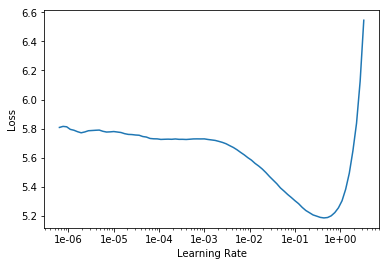

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(20, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.960902,3.501057,0.370941,05:03
1,3.511514,3.126700,0.419497,05:03
2,3.295578,3.000760,0.433932,05:03
3,3.181963,2.975953,0.436971,05:03
4,3.139009,2.973102,0.436015,05:04
5,3.040317,2.975095,0.438588,05:03
6,2.996011,2.979198,0.437218,05:04
7,2.881905,2.976108,0.440004,05:04
8,2.882665,2.963390,0.441521,05:03
9,2.848098,2.964565,0.440570,05:03


Buffered data was truncated after reaching the output size limit.

In [0]:
learn.save('s1')

## Fine tune

In [0]:
learn.unfreeze()

In [18]:
learn.fit_one_cycle(20, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.341699,2.779054,0.471573,06:02
1,2.479545,2.781599,0.471737,06:02
2,2.647263,2.785634,0.474098,06:02
3,2.781404,2.828656,0.468745,06:02
4,2.889367,2.838465,0.469993,06:02
5,2.842607,2.834444,0.470435,06:02
6,2.778823,2.801241,0.474556,06:01
7,2.716709,2.768827,0.478977,06:01
8,2.675259,2.741563,0.483474,06:01
9,2.571604,2.722477,0.484910,06:01


Buffered data was truncated after reaching the output size limit.

In [0]:
learn.save('f1')

In [0]:
TEXT = "what"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

In [0]:
learn.save_encoder('f2enc')

# Classifier

## Prepare classifier data

In [0]:
clasdata = (TextList.from_df(train_csv,cols=['Title','Body'], vocab=lmdata.vocab)
             .split_by_rand_pct(.2)
             .label_from_df(cols=3,label_delim=' ')
             .databunch(bs=bs))

In [24]:
clasdata.show_batch()

text,target
"xxbos xxmaj how to adds multiple images with delete add images in iphone ? < p > i want add multiple images in my own project like 7 images but in delete and add images is troubles . i also add images successfully . xxmaj and more also delete success . xxmaj but when i added with delete image , the image position was moved incorrect position . xxmaj can",image;iphone;uiimage;xcode
xxbos xxunk ios6 crash on resume ( xxup exc_bad_access ) < p > xxmaj the phenomenon : < / p > \n \n < p > happens only on ios6 not happening on ios5 < / p > \n \n < p > xxmaj app is suspended ( click on power btn on top ) and immediately ( xxunk - 2 sec ) resumed -- > no issue,ios6;iphone;phonegap
"xxbos xxmaj webkit xxmaj scrollbar disappears when page is reloaded < p > i just downloaded this template from < a href=""http : / / xxunk / "" xxunk < / a > and i noticed that i ca n't use the webkit scrollbar properly . i have another page with the same exact css webkit code and it works perfectly . xxmaj when i load the faulty page from",css;webkit
xxbos xxmaj receiving xxmaj index xxmaj out of xxmaj range with nhibernate < p > xxmaj i'm hoping that someone can help me with this issue . i 've been xxunk \n my brain and my project is due very soon . xxmaj thank xxmaj you in advance . < / p > \n \n < p > xxmaj i'm receiving an index out of range exception when,nhibernate;nhibernate-mapping
"xxbos xxup sql xxmaj server lock issue ( distributed transactions with xxup wcf ) < p > xxmaj i'm having a problem with distributed transactions . < / p > \n \n < p > xxmaj i'm using xxup sql xxmaj server 2008 xxup r2 , xxmaj windows 7 , .net 4.0 . < / p > \n \n < p > xxmaj here 's what i actually",c#;soap;sql-server;transactions;wcf


## Train classifier

In [0]:
clslearn = text_classifier_learner(clasdata,AWD_LSTM,drop_mult=.5,path='.')
# load language model
clslearn.load_encoder('f2enc')
clslearn.freeze()

In [26]:
clslearn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


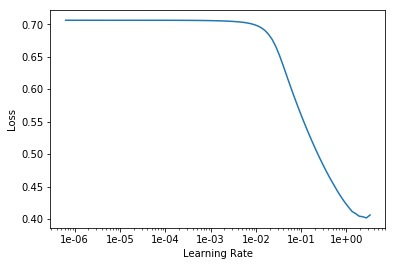

In [27]:
clslearn.recorder.plot()

In [28]:
clslearn.fit_one_cycle(20, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.256046,0.070433,02:49
1,0.018491,0.004906,02:45
2,0.004566,0.003167,02:44
3,0.003639,0.002772,02:43
4,0.003481,0.002654,02:40
5,0.003351,0.002504,02:51
6,0.003176,0.002461,02:50
7,0.003083,0.002404,02:44
8,0.002950,0.002384,02:36
9,0.002857,0.002408,02:37


# Predictions

Preparing a dataframe for validation predictions

In [0]:
valid_preds = pd.DataFrame(columns=['Text','Actual Tags','Predicted Tags'])

Threshold for selecting a label. A label should have at least this much probabilty to be considered.

In [0]:
thresh = .2

In [0]:
from fastprogress import progress_bar

In [0]:
progbar = progress_bar(range(len(clslearn.data.valid_ds)))

In [214]:
for i in progbar:
  valid_item = clslearn.data.valid_ds[i]
  text = str(valid_item[0])
  actuals = str(valid_item[1])
  
  # make predictions
  pred = clslearn.predict(text)
  probs = np.array(pred[2])
  labels=";".join(list(classes[probs>thresh]))
  
  # add row
  valid_preds.loc[i]=[text,actuals,labels]

Results on validation set:

In [215]:
valid_preds.head(20)

,Text,Actual Tags,Predicted Tags
0,xxbos xxmaj how to block the mysql export opti...,mysql,database;mysql
1,xxbos xxmaj share itunes music but not podcast...,itunes;sharing,audio;video
2,xxbos xxmaj can i use routes to influence whic...,networking;linux;multicast,networking;openvpn;quagga;router;routing
3,"xxbos xxmaj different uses for runat=""server ""...",javascript;asp.net,ajax;asp.net;javascript
4,xxbos xxmaj infinite pop up error while using ...,jquery;android;html5;phonegap,android;jquery;jquery-mobile;phonegap
5,xxbos xxmaj difference between shutdown and sh...,java;java.util.concurrent,multithreading
6,xxbos xxmaj eclipse xxup xxunk with c running ...,c;eclipse,c++
7,xxbos xxmaj exporting html table to xxunk exce...,php;javascript;export-to-excel,php
8,xxbos does xxunk : animations : block main thr...,iphone;objective-c;cocoa-touch;animation;multi...,ios;iphone;objective-c;xcode
9,xxbos xxmaj spring dependency injection : xxma...,java;spring;dependency-injection,java;spring


Save to csv

In [0]:
valid_preds.to_csv('predictions.csv',index=False)